In [1]:
# Preprocessing & results----------------
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import spacy
# Models-------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kls
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# for visualizing ---------------
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image
# General purpose
import re
import pandas as pd
import numpy as np

/usr/local/lib/python3.5/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


**Mount Drive**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Load the Features data**

In [3]:
# Load the data
data_raw = pd.read_pickle('./features/features_csv_17_20.pkl')

In [4]:
data_raw.head(3)

,id,original,number,cdate,tcdate,tmdate,ddate,content,forum,referent,...,year_z,title,authors,abstract,keywords,replyCount,label,ref_latest,ref_len,ref_years
HJWHIKqgl,HJWHIKqgl,None,494,None,1478297149874,1559850667018,None,"{'conflicts': ['cmu.edu', 'berkeley.edu', 'ucl...",HJWHIKqgl,None,...,2017,Generative Models and Model Criticism via Opti...,"[Dougal J. Sutherland, Hsiao-Yu Tung, Heiko St...",We propose a method to optimize the representa...,[Unsupervised Learning],12,Accept,2019,34,"[2008, 2016, 2011, 2015, 2015, 2008, 2014, 200..."
SyK00v5xx,SyK00v5xx,None,448,None,1478291152993,1544202244497,None,"{'conflicts': ['cs.princeton.edu'], 'authors':...",SyK00v5xx,None,...,2017,A Simple but Tough-to-Beat Baseline for Senten...,"[Sanjeev Arora, Yingyu Liang, Tengyu Ma]",\nThe success of neural network methods for co...,"[Natural language processing, Unsupervised Lea...",19,Accept,2016,49,"[2012, 2012, 2013, 2013, 2014, 2015, 2016, 200..."
Hkg4TI9xl,Hkg4TI9xl,None,331,None,1478286631603,1543468347892,None,"{'conflicts': ['uchicago.edu', 'ttic.edu'], 'a...",Hkg4TI9xl,None,...,2017,A Baseline for Detecting Misclassified and Out...,"[Dan Hendrycks, Kevin Gimpel]",We consider the two related problems of detect...,[Computer vision],12,Accept,2016,41,"[2016, 2012, 2011, 2006, 2005, 1993, 2011, 201..."


In [6]:
print(len(data_raw))

3446


**Read original data to construct new features**

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Feature Engineering**

In [0]:
def ml_keywords_present(abstract):
    # collected from sense2vec spacy
    ml_keywords = ["outperforms", "outperform", "novel", "machine learning", "deep learning", "neural nets", "neural networks", "rnns", "rnn", "cnn", "cnns", "attention", "lstm", "adversarial network"]
    for keyw in ml_keywords:
        if abstract.lower().find(keyw) > -1:
            return 1
    return 0

In [0]:
data.head(2)

,id,abs,contains_ml_keyword
HJWHIKqgl,HJWHIKqgl,We propose a method to optimize the representa...,1
SyK00v5xx,SyK00v5xx,\nThe success of neural network methods for co...,1


# Preprocessing

In [0]:
# Feature creation--------------------
data = pd.DataFrame()
data['id'] = data_raw['id']#.value_counts()
data['n_authors'] = data_raw['authors'].apply(len)#.value_counts()
data['len_char_title'] = data_raw['title'].apply(len)
data['len_word_title'] = data_raw['title'].apply(lambda x: len(re.split(':|\s',x)))
data['len_char_abstract'] = data_raw['abstract'].apply(len)
data['len_word_abstract'] = data_raw['abstract'].apply(lambda x: len(re.split(':|\s',x)))
# data['replyCount'] = data_raw['replyCount']
data['n_keywords'] = data_raw['keywords'].apply(len)
data['ref_len'] = data_raw['ref_len']
data['ref_latest'] = data_raw['ref_latest']
data['label'] = data_raw['label']
data['contains_ml_keyword'] = data_raw['abstract'].apply(ml_keywords_present)
# data.head(10)
#data.to_pickle('/content/drive/My Drive/Colab Notebooks/ML Project/data/data-2017-20.pkl')

,id,label,contains_ml_keyword
HJWHIKqgl,HJWHIKqgl,Accept,1
SyK00v5xx,SyK00v5xx,Accept,1
Hkg4TI9xl,Hkg4TI9xl,Accept,0
Hk1iOLcle,Hk1iOLcle,Reject,0
H178hw9ex,H178hw9ex,Reject,1
S1TER2oll,S1TER2oll,Accept,1
B1Igu2ogg,B1Igu2ogg,Accept,0
r1X3g2_xl,r1X3g2_xl,Accept,0
r1Ue8Hcxg,r1Ue8Hcxg,Accept,1
rkEFLFqee,rkEFLFqee,Accept,1


In [0]:
# shuffle the data
data = data.sample(n=len(data), random_state=42)

In [0]:
len(data)

3446

# Decision Tree

In [0]:
max_depth = 1

In [0]:
clf = DecisionTreeClassifier(max_depth=max_depth)
X = data.drop(columns=['id','label'])
y = data['label']
results = cross_validate(clf, X, y, return_estimator=True)
clf = results['estimator']
results.pop('estimator')
print('Mean accuracy', np.mean(results['test_score']),end='\n\n')
results

Mean accuracy 0.5156677394249174



{'fit_time': array([0.00626588, 0.00986052, 0.00687027, 0.00509429, 0.00517249]),
 'score_time': array([0.00258446, 0.00290275, 0.00246215, 0.00248075, 0.00229359]),
 'test_score': array([0.52463768, 0.52249637, 0.50798258, 0.53991292, 0.48330914])}

In [0]:
clf = DecisionTreeClassifier(max_depth=max_depth)
X = data.drop(columns=['id','label'])
y = data['label']
results = cross_validate(clf, X, y, return_estimator=True)
clf = results['estimator']
results.pop('estimator')
print('Mean accuracy', np.mean(results['test_score']),end='\n\n')
results

Mean accuracy 0.5226368818493511



{'fit_time': array([0.01360774, 0.00510454, 0.00499296, 0.00489664, 0.00486231]),
 'score_time': array([0.00236177, 0.00216484, 0.00217557, 0.00218225, 0.00217628]),
 'test_score': array([0.51594203, 0.51814224, 0.53265602, 0.52685051, 0.51959361])}

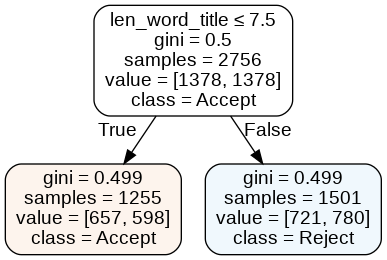

In [0]:
# To plot the Tree--------------------------------------------
dot_data = StringIO()
tree.export_graphviz(clf[0], 
 out_file=dot_data, 
 class_names=['Accept','Reject'], # the target names.
 feature_names=X.columns, # the feature names.
 filled=True, # Whether to fill in the boxes with colours.
 rounded=True, # Whether to round the corners of the boxes.
 special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [0]:
for est in clf:
  print(tree.export_text(est))

|--- feature_0 <= 7.50
|   |--- class: Accept
|--- feature_0 >  7.50
|   |--- class: Reject

|--- feature_0 <= 7.50
|   |--- class: Accept
|--- feature_0 >  7.50
|   |--- class: Reject

|--- feature_0 <= 4.50
|   |--- class: Accept
|--- feature_0 >  4.50
|   |--- class: Reject

|--- feature_0 <= 7.50
|   |--- class: Accept
|--- feature_0 >  7.50
|   |--- class: Reject

|--- feature_0 <= 4.50
|   |--- class: Accept
|--- feature_0 >  4.50
|   |--- class: Reject



# Random Forest

In [0]:
max_depth = 2

In [0]:
clf = RandomForestClassifier(max_depth=max_depth)
X = data.drop(columns=['id','label'])
y = data['label']
results = cross_validate(clf, X, y, return_estimator=True)
clf = results['estimator'][0]
results.pop('estimator')
print('Mean accuracy', np.mean(results['test_score']),end='\n\n')
results

Mean accuracy 0.6213096064449634



{'fit_time': array([0.21503806, 0.2315886 , 0.23422408, 0.23867297, 0.25186682]),
 'score_time': array([0.01290011, 0.01316667, 0.01447058, 0.02057505, 0.01792979]),
 'test_score': array([0.5884058 , 0.64150943, 0.62119013, 0.65312046, 0.60232221])}

# Logistic Regression

In [0]:
max_iter = 5000

In [0]:
clf = LogisticRegression(max_iter=max_iter)
X = data.drop(columns=['id','label'])
y = data['label']
results = cross_validate(clf, X, y, return_estimator=True)
clf = results['estimator'][0]
results.pop('estimator')
print('Mean accuracy', np.mean(results['test_score']),end='\n\n')
results

Mean accuracy 0.6300056793083865



{'fit_time': array([0.09690595, 0.1041317 , 0.06139374, 0.05649161, 0.070225  ]),
 'score_time': array([0.00445056, 0.00445819, 0.00440788, 0.00438285, 0.00447059]),
 'test_score': array([0.63043478, 0.62264151, 0.64586357, 0.63134978, 0.61973875])}

# Logistic Regression (Lasso)

In [0]:
max_iter = 5000

In [0]:
clf = LogisticRegression(max_iter=max_iter, penalty='l1',solver='liblinear')
X = data.drop(columns=['id','label'])
y = data['label']
results = cross_validate(clf, X, y, return_estimator=True)
clf = results['estimator'][0]
results.pop('estimator')
print('Mean accuracy', np.mean(results['test_score']),end='\n\n')
results

Mean accuracy 0.6317460718116994



{'fit_time': array([0.35614204, 0.39271069, 0.36434269, 0.35002446, 0.3365624 ]),
 'score_time': array([0.00297022, 0.00380874, 0.002949  , 0.0029459 , 0.00342345]),
 'test_score': array([0.63478261, 0.62699565, 0.64731495, 0.62844702, 0.62119013])}

# Ridge Classifier

In [0]:
max_iter = 5000

In [0]:
clf = RidgeClassifier(max_iter=max_iter)
X = data.drop(columns=['id','label'])
y = data['label']
results = cross_validate(clf, X, y, return_estimator=True)
clf = results['estimator'][0]
results.pop('estimator')
print('Mean accuracy', np.mean(results['test_score']),end='\n\n')
results

Mean accuracy 0.6279754317326097



{'fit_time': array([0.01809096, 0.02373838, 0.0227356 , 0.02274466, 0.02232003]),
 'score_time': array([0.00418782, 0.00428748, 0.00422764, 0.00414014, 0.00411463]),
 'test_score': array([0.62463768, 0.63280116, 0.64876633, 0.62119013, 0.61248186])}

# Support Vector Classifier

In [0]:
kernal = 'poly'

In [0]:
clf = SVC(kernel=kernal)
X = data.drop(columns=['id','label'])
y = data['label']
results = cross_validate(clf, X, y, return_estimator=True)
clf = results['estimator'][0]
results.pop('estimator')
print('Mean accuracy', np.mean(results['test_score']),end='\n\n')
results

Mean accuracy 0.5542668433562609



{'fit_time': array([0.23265696, 0.20871639, 0.21271348, 0.21392727, 0.21734619]),
 'score_time': array([0.02973747, 0.0297904 , 0.0307641 , 0.02920008, 0.02964807]),
 'test_score': array([0.55072464, 0.57329463, 0.54862119, 0.5616836 , 0.53701016])}

# Gaussian Naive Bayes

In [0]:
clf = GaussianNB()
X = data.drop(columns=['id','label'])
y = data['label']
results = cross_validate(clf, X, y, return_estimator=True)
clf = results['estimator'][0]
results.pop('estimator')
print('Mean accuracy', np.mean(results['test_score']),end='\n\n')
results

Mean accuracy 0.6120123682715972



{'fit_time': array([0.02448487, 0.00734901, 0.00788641, 0.00789499, 0.00738764]),
 'score_time': array([0.00354028, 0.00310588, 0.00296926, 0.00308084, 0.00346804]),
 'test_score': array([0.6173913 , 0.60667634, 0.62554427, 0.62844702, 0.5820029 ])}

# Neural Network

In [0]:
activation = 'logistic'

In [0]:
clf = MLPClassifier((50),activation=activation)
X = data.drop(columns=['id','label'])
y = data['label']
results = cross_validate(clf, X, y, return_estimator=True)
clf = results['estimator'][0]
results.pop('estimator')
print('Mean accuracy', np.mean(results['test_score']),end='\n\n')
results

Mean accuracy 0.5678904524515682



{'fit_time': array([1.84536624, 1.54787254, 1.18014121, 0.41644526, 2.12680316]),
 'score_time': array([0.00618219, 0.00603962, 0.0059948 , 0.00601554, 0.00601888]),
 'test_score': array([0.6173913 , 0.5341074 , 0.53555878, 0.53265602, 0.61973875])}

# K-Neighbors Classifier

In [0]:
n_neighbors = 10

In [0]:
clf = KNeighborsClassifier(n_neighbors=n_neighbors)
X = data.drop(columns=['id','label'])
y = data['label']
results = cross_validate(clf, X, y, return_estimator=True)
clf = results['estimator'][0]
results.pop('estimator')
print('Mean accuracy', np.mean(results['test_score']),end='\n\n')
results

Mean accuracy 0.551076334111609



{'fit_time': array([0.0153501 , 0.00787282, 0.00791454, 0.00802517, 0.00767446]),
 'score_time': array([0.02700067, 0.02501702, 0.02525926, 0.02593374, 0.02882266]),
 'test_score': array([0.54202899, 0.56603774, 0.54281567, 0.58055152, 0.52394775])}

# Gaussian Processes

In [0]:
kernel = kls.RBF

In [0]:
clf = GaussianProcessClassifier(kernel=kernal)
X = data.drop(columns=['id','label'])
y = data['label']
results = cross_validate(clf, X, y, return_estimator=True)
clf = results['estimator'][0]
results.pop('estimator')
print('Mean accuracy', np.mean(results['test_score']),end='\n\n')
results

Mean accuracy nan



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
AttributeError: 'str' object has no attribute 'requires_vector_input'

  FitFailedWarning)


{'fit_time': array([0.00196433, 0.00119424, 0.00160885, 0.00118065, 0.00130773]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([nan, nan, nan, nan, nan])}

['ABCMeta',
 'CompoundKernel',
 'ConstantKernel',
 'DotProduct',
 'ExpSineSquared',
 'Exponentiation',
 'GenericKernelMixin',
 'Hyperparameter',
 'Kernel',
 'KernelOperator',
 'Matern',
 'NormalizedKernelMixin',
 'PairwiseKernel',
 'Product',
 'RBF',
 'RationalQuadratic',
 'StationaryKernelMixin',
 'Sum',
 'WhiteKernel',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_approx_fprime',
 '_check_length_scale',
 '_num_samples',
 'abstractmethod',
 'cdist',
 'clone',
 'gamma',
 'kv',
 'math',
 'namedtuple',
 'np',
 'pairwise_kernels',
 'pdist',
 'signature',
 'squareform',
 'warnings']